# Obesity Risk Prediction with Neural Networks, Cross Validation, and Hyperparameter Tuning

## Introduction
In this Kaggle notebook, I analyze the Estimation of Obesity Levels dataset from the UC Irvine Machine Learning Repository. This dataset offers insights into how eating habits and physical conditions correlate with obesity levels, with the goal of building effective predictive models using neural networks.

You can check this model in action in this Streamlit App.

## Dataset Overview
We are using a custom-modified version of the dataset that I uploaded to Kaggle, which includes:

- **original_data.csv**: Raw data with random NULL values.
- **data_ready.csv**: A cleaned and imputed subset of 1,000 samples for model training and testing. Columns 'gender' and 'Weight' were removed to enhance model performance and avoid collinearity.
- **test_later.csv**: Additional data for final model evaluation.

## Model Training and Evaluation
Two neural network models were trained and tuned using cross-validation. The key results for the best performing neural network are:

### On `data_ready.csv`:
- **Accuracy**: 0.69

|              | precision | recall | f1-score | support |
|--------------|-----------|--------|----------|---------|
| **0**        | 0.88      | 0.45   | 0.60     | 102     |
| **1**        | 0.62      | 0.94   | 0.75     | 98      |
| **accuracy** |           |        | 0.69     | 200     |
| **macro avg**| 0.75      | 0.69   | 0.67     | 200     |
| **weighted avg**| 0.76  | 0.69   | 0.67     | 200     |

### On `test_later.csv`:
- **Accuracy**: 0.75

|              | precision | recall | f1-score | support |
|--------------|-----------|--------|----------|---------|
| **0**        | 0.93      | 0.56   | 0.70     | 539     |
| **1**        | 0.67      | 0.96   | 0.78     | 491     |
| **accuracy** |           |        | 0.75     | 1030    |
| **macro avg**| 0.80      | 0.76   | 0.74     | 1030    |
| **weighted avg**| 0.81  | 0.75   | 0.74     | 1030    |

The recall for identifying obesity, our primary objective, shows a strong performance, reflecting the model’s effectiveness in detecting individuals with obesity. This notebook details the model development process, including data preprocessing, feature engineering, and hyperparameter tuning.

# Importing Libraries and Defining Functions

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from keras_tuner import RandomSearch, HyperModel
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.metrics import Recall

2024-08-06 14:42:19.513391: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 14:42:19.513856: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 14:42:19.516010: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-06 14:42:19.522677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 14:42:19.533580: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
def prep_data(datos_input, var_cont, var_categ):
    di_cont = []
    di_cat = []
    if len(var_cont) != 0:
        di_cont = pd.DataFrame(datos_input[var_cont], columns = var_cont)
    if len(var_categ) != 0:
        di_cat = datos_input[var_categ]
        di_cat = pd.get_dummies(di_cat, columns = var_categ, drop_first = True, dtype=int)
    if len(var_cont) == 0:
        data_input = pd.concat([di_cat], axis=1)
    elif len(var_categ) == 0:
        data_input = pd.concat([di_cont], axis=1)
    else:
        data_input = pd.concat([di_cont,di_cat], axis=1)
    return data_input, di_cont, di_cat
def convert_binary_columns_to_str(df: pd.DataFrame) -> pd.DataFrame:
    # Iterate through each column in the DataFrame
    for column in df.columns:
        unique_values = df[column].dropna().unique()
        # Check if the column contains exactly two unique values and they are 0 and 1
        if len(unique_values) == 2 and set(unique_values) == {0, 1}:
            # Convert the column to type str
            df[column] = df[column].astype(str)
    return df
def DataPrep(data, data2):
    y = data['NObeyesdad'].astype(int)
    del data['NObeyesdad']
    y2 = data2['NObeyesdad']
    del data2['NObeyesdad']
    data = convert_binary_columns_to_str(data)
    data2 = convert_binary_columns_to_str(data2)
    categ = data.select_dtypes(include=['object', 'category']).columns.tolist()
    cont = data.select_dtypes(exclude=['object', 'category']).columns.tolist()
    data_inputn, di_contn, di_catn = prep_data(data, cont, categ)
    X = data_inputn.copy()
    X2 = data2.copy()
    inputs, cont, categ = prep_data(X2, cont, categ)
    return X, y, inputs, y2
def TestModelAccuracy(model,X_test,y_test):
    y_pred = model.predict(X_test)
    # Convert probabilities to binary class labels
    y_pred = (y_pred > 0.5).astype(int).flatten()
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# Data Prep
As mentioned above, I am using a modified version of the Estimation of Obesity Levels Based On Eating Habits and Physical Condition from UC Irvine. I will upload a notebook with the respective EDA in the future :)

In [3]:
seed = 7679

In [4]:
data = pd.read_csv('data/data_ready.csv')
data2 = pd.read_csv('data/test_later.csv')
data.head()

,Age,Height,FCVC,NCP,CH2O,FAF,TUE,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
0,20.738469,1.759933,2.627031,3.832911,2.993448,2.000000,1.425903,1,1,Sometimes,0,0,no,Public_Transport_Walking,0.0
1,29.721964,1.918859,2.041376,3.000000,1.120213,1.055450,0.000000,1,1,Sometimes,0,0,Sometimes_Frequently_Always,Public_Transport_Walking,1.0
2,24.825393,1.603501,2.996186,1.134042,1.270166,0.073065,1.551934,1,1,Sometimes,0,0,no,Public_Transport_Walking,1.0
3,20.811580,1.741193,3.000000,3.000000,1.768111,0.616503,0.968151,1,1,Sometimes,0,0,Sometimes_Frequently_Always,Public_Transport_Walking,1.0
4,18.000000,1.770000,3.000000,3.000000,2.000000,1.000000,1.000000,1,1,Sometimes,0,0,Sometimes_Frequently_Always,Public_Transport_Walking,0.0


In [5]:
X, y, inputs, y2 = DataPrep(data, data2)

In [6]:
selector = SelectKBest(score_func=f_classif, k=5)

X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
inputs = inputs[selected_features]

In [7]:
selected_features

Index(['Age', 'family_history_with_overweight_1', 'FAVC_1', 'CAEC_Sometimes',
       'SCC_1'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=seed)

# Traininig the Neural Network
Let's train the first Neural Network with only 1 hidden layer:

In [9]:
def FirstNN(X_train, y_train):
    # Red Neuronal con una sola capa oculta
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Hidden layer with 64 neurons
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    # Compile the model with AUC as a metric
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=[Recall()])
    
    # Fit the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
    
    return model

In [10]:
model1 = FirstNN(X_train,y_train)

Epoch 1/100


/home/juancarlos/anaconda3/envs/mldev/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1722948140.579208   87226 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 14:42:20.579492: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8954 - recall: 1.0000 - val_loss: 1.1732 - val_recall: 1.0000
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9101 - recall: 0.7162 - val_loss: 0.7244 - val_recall: 0.0000e+00
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7661 - recall: 0.0305 - val_loss: 0.7161 - val_recall: 0.5902
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7192 - recall: 0.3756 - val_loss: 0.6888 - val_recall: 0.0820
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7147 - recall: 0.0567 - val_loss: 0.6879 - val_recall: 0.1148
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6997 - recall: 0.0815 - val_loss: 0.6817 - val_recall: 0.0984
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6884 - recall: 0.1197 - val_loss: 0.6783 - val_recall: 0.1148
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6909 - recall: 0.0511 - val_loss: 0.6719 - val_recall: 0.0164
Epoch 9/100
20/20 ━━━━━━

# Hyperparameter Tuning
Now, we will dive into Hyperparameter Tuning using 2 hidden layers:

In [11]:
def HyperModel(hp):
    model = Sequential()
    # Tune the number of units in the first hidden layer
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    model.add(Dense(units=hp_units_1, activation='relu', input_dim=X_train.shape[1]))
    
    # Tune the number of units in the second hidden layer
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    model.add(Dense(units=hp_units_2, activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=[Recall()])
    return model
tuner = RandomSearch(
    HyperModel,
    objective='val_recall',
    max_trials=10,
    executions_per_trial=3,
)

In [12]:
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

Trial 10 Complete [00h 00m 15s]
val_recall: 0.9562841455141703

Best val_recall So Far: 1.0
Total elapsed time: 00h 02m 33s


In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [14]:
modelBest = tuner.hypermodel.build(best_hps)
history = modelBest.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7391 - recall_2: 0.4059 - val_loss: 0.6894 - val_recall_2: 0.8852
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6794 - recall_2: 0.3616 - val_loss: 0.6685 - val_recall_2: 0.2459
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6785 - recall_2: 0.4833 - val_loss: 0.6573 - val_recall_2: 0.0492
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6582 - recall_2: 0.5904 - val_loss: 0.6588 - val_recall_2: 0.7377
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6440 - recall_2: 0.6940 - val_loss: 0.7166 - val_recall_2: 1.0000
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6513 - recall_2: 0.8512 - val_loss: 0.6358 - val_recall_2: 0.3443
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6316 - recall_2: 0.4390 - val_loss: 0.6327 - val_recall_2: 0.0000e+00
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6298 - recall_2: 0.5091 - val_loss: 0.6376 - val_recal

# Testing the Models

## Manual Model

In [15]:
auc = roc_auc_score(y_test, (model1.predict(X_test) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.70


In [16]:
auc = roc_auc_score(y2, (model1.predict(inputs) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
AUC: 0.76


In [17]:
TestModelAccuracy(model1,X_test,y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
Accuracy: 0.7
[[48 54]
 [ 6 92]]
              precision    recall  f1-score   support

           0       0.89      0.47      0.62       102
           1       0.63      0.94      0.75        98

    accuracy                           0.70       200
   macro avg       0.76      0.70      0.68       200
weighted avg       0.76      0.70      0.68       200



In [18]:
TestModelAccuracy(model1,inputs,y2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
Accuracy: 0.7524271844660194
[[306 233]
 [ 22 469]]
              precision    recall  f1-score   support

           0       0.93      0.57      0.71       539
           1       0.67      0.96      0.79       491

    accuracy                           0.75      1030
   macro avg       0.80      0.76      0.75      1030
weighted avg       0.81      0.75      0.74      1030



## Hyperparameter Model

In [19]:
auc = roc_auc_score(y_test, (modelBest.predict(X_test) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
AUC: 0.71


In [20]:
auc = roc_auc_score(y2, (modelBest.predict(inputs) > 0.5).astype(int).flatten())
print("AUC: {:.2f}".format(auc))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
AUC: 0.77


In [22]:
TestModelAccuracy(modelBest,X_test,y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
Accuracy: 0.705
[[50 52]
 [ 7 91]]
              precision    recall  f1-score   support

           0       0.88      0.49      0.63       102
           1       0.64      0.93      0.76        98

    accuracy                           0.70       200
   macro avg       0.76      0.71      0.69       200
weighted avg       0.76      0.70      0.69       200



In [23]:
TestModelAccuracy(modelBest,inputs,y2)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
Accuracy: 0.7611650485436893
[[317 222]
 [ 24 467]]
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       539
           1       0.68      0.95      0.79       491

    accuracy                           0.76      1030
   macro avg       0.80      0.77      0.76      1030
weighted avg       0.81      0.76      0.75      1030



In [31]:
from sklearn.metrics import precision_recall_curve
def find_optimal_threshold_nn(model, X_test, y_test, min_precision=0.7):
    """
    Find the optimal threshold for a given neural network model to maximize recall while maintaining a minimum precision.

    Parameters:
    model : trained neural network model
        The trained neural network model.
    X_test : numpy array or pandas DataFrame
        The test features.
    y_test : numpy array or pandas Series
        The true labels for the test set.
    min_precision : float
        The minimum acceptable precision value.

    Returns:
    float
        The optimal threshold value that maximizes recall while maintaining the minimum precision.
    """
    
    # Get the predicted probabilities for the positive class
    y_prob = model.predict(X_test).ravel()

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    # Initialize variables to track the optimal threshold
    optimal_threshold = 0.5  # Default threshold
    max_recall = 0

    # Find the threshold that maximizes recall while keeping precision above min_precision
    for i in range(len(precision)):
        if precision[i] >= min_precision:
            optimal_threshold = thresholds[i]
            max_recall = recall[i]
            break

    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Precision at Optimal Threshold: {precision[i]}")
    print(f"Max Recall at Optimal Threshold: {max_recall}")

    return optimal_threshold

In [32]:
optimal_threshold = find_optimal_threshold_nn(modelBest, X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
Optimal Threshold: 0.6214653253555298
Precision at Optimal Threshold: 0.7053571428571429
Max Recall at Optimal Threshold: 0.8061224489795918


In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve_nn(model, X_test, y_test):
    """
    Plot the precision-recall curve for a given neural network model with AUC.

    Parameters:
    model : trained neural network model
        The trained neural network model.
    X_test : numpy array or pandas DataFrame
        The test features.
    y_test : numpy array or pandas Series
        The true labels for the test set.
    """
    
    # Get the predicted probabilities for the positive class
    y_prob = model.predict(X_test).ravel()  # Flatten if necessary

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    # Compute the AUC
    pr_auc = auc(recall, precision)

    # Plot the precision-recall curve
    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
    plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


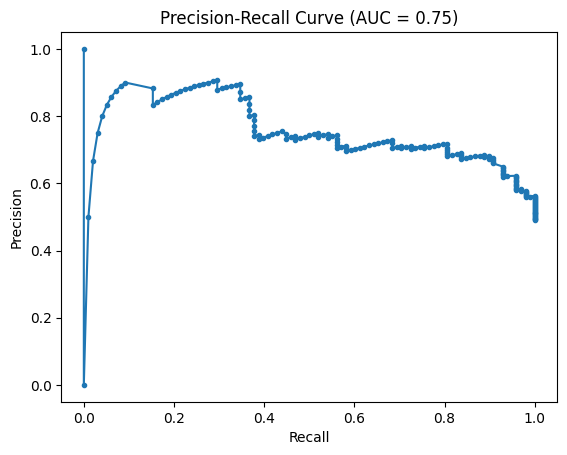

In [40]:
plot_precision_recall_curve_nn(modelBest, X_test, y_test)

In [41]:
import pickle

with open('NN_Model.pkl', 'wb') as file:
    pickle.dump((modelBest,optimal_threshold), file)